In [1]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import sklearn
import os
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
import scipy

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [3]:
nose_front_pts = np.array([  4,   5,   6, 168, 195, 197])
nose_base_pts = np.array([  2,  19,  20,  60,  94,  97,  99, 125, 141, 238, 241, 242, 250, 290, 326, 328, 354, 370, 458, 461, 462])
nose_base_pts = np.array([1, 2,  19,  94])
lower_lip_pts = np.array([61,146,91,181,84,17,314,405,321,375,291,308,324,318,402,317,14,87,178,88,95,78])
upper_lip_pts = np.array([61,185,40,39,37,0,267,269,270,409,291,308,415,310,311,312,13,82,81,80,191,78,])


nose_pts = np.array([  1,   2,   3,   4,   5,   6,  19,  20,  44,  45,  48,  49,  51,
        59,  60,  64,  75,  79,  94,  97,  98,  99, 102, 114, 115, 122,
       125, 128, 129, 131, 134, 141, 166, 168, 174, 188, 193, 195, 196,
       197, 198, 203, 217, 218, 219, 220, 235, 236, 237, 238, 239, 240,
       241, 242, 244, 245, 248, 250, 274, 275, 278, 279, 281, 289, 290,
       294, 305, 309, 326, 327, 328, 331, 343, 344, 351, 354, 357, 358,
       360, 363, 370, 392, 399, 412, 417, 419, 420, 423, 437, 438, 439,
       440, 455, 456, 457, 458, 459, 460, 461, 462, 464, 465])
nose_left_pt = 102
nose_right_pt = 331

eye_left_left_pt = 33
eye_left_right_pt = 133
eye_left_up_pt = 159
eye_left_down_pt = 144

eye_right_left_pt = 362
eye_right_right_pt = 263
eye_right_up_pt = 386
eye_right_down_pt = 373

see metrics:

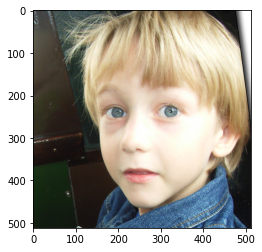

nose angle: 1.4274794204060375
nose area: 0.02694604876487231
nose_width: 0.14250785035956584
lips area: 0.008741618403341532
eyes_ratio: 0.44763800914988006


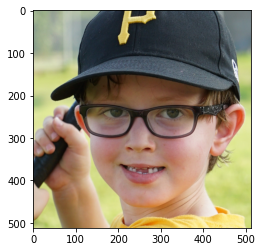

nose angle: 1.2155172549573312
nose area: 0.026174483829677277
nose_width: 0.18314342152903293
lips area: 0.015045761193508594
eyes_ratio: 0.35105856814483755


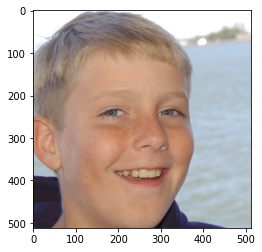

nose angle: 1.229100564124627
nose area: 0.03269064419737807
nose_width: 0.1988599998300372
lips area: 0.018859484602714114
eyes_ratio: 0.29268579041391585


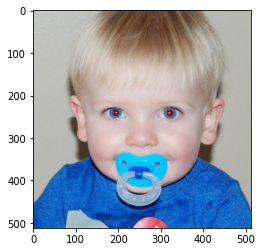

nose angle: 1.3577746821907997
nose area: 0.022366316269519806
nose_width: 0.15795122437418613
lips area: 0.009220474285322765
eyes_ratio: 0.4367457553880243


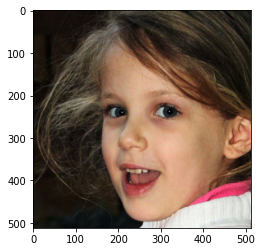

nose angle: 1.3116822048916292
nose area: 0.0272166688728476
nose_width: 0.17104767684631722
lips area: 0.023467410019375905
eyes_ratio: 0.3985485569376592


In [4]:
foldername = "CeterisParibusDataset"
# foldername = "test"
IMAGE_FILES = [foldername+'/'+filename for filename in os.listdir(foldername) if 'png' in filename or 'jpg' in filename]

face_mesh =  mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5)

for filename in IMAGE_FILES[:5]:
    print('='*50)
    image = cv2.imread(filename)
    plt.imshow(image[:,:,::-1])
    plt.show()
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    face_landmarks = results.multi_face_landmarks[0]
    data = []
    for pt in face_landmarks.landmark:
        data.append([pt.x, pt.y, pt.z])
    data = np.array(data)

    pca = PCA(n_components=3)
    pca.fit(data)
    trans_data = pca.transform(data)

    #nose angle
    nose_front_data = data[nose_front_pts]
    nose_base_data = data[nose_base_pts]
    uu, dd, vv = np.linalg.svd(nose_base_data - nose_base_data.mean(axis=0))
    b = vv[0]
    uu, dd, vv = np.linalg.svd(nose_front_data - nose_front_data.mean(axis=0))
    d = vv[0]
    nose_angle = np.arccos( np.dot(b, d) / (np.linalg.norm(d)*np.linalg.norm(b)) )
    print("nose angle:", nose_angle)

    #nose area
    nose_data = data[nose_pts]
    trans_nose_data = pca.transform(nose_data)
    nose_hull = ConvexHull(trans_nose_data[:,:2])
    nose_area = nose_hull.volume
    print("nose area:", nose_area)

    #nose width
    nose_left = trans_data[nose_left_pt]
    nose_right = trans_data[nose_right_pt]
    nose_width = np.linalg.norm(nose_left-nose_right)
    print("nose_width:", nose_width)

    #lips area
    lower_lip = data[lower_lip_pts]
    trans_lower_lip = pca.transform(lower_lip)
    lower_lip_hull = ConvexHull(trans_lower_lip[:,:2])
    lower_lip_area = lower_lip_hull.volume
    upper_lip = data[upper_lip_pts]
    trans_upper_lip = pca.transform(upper_lip)
    upper_lip_hull = ConvexHull(trans_upper_lip[:,:2])
    upper_lip_area = upper_lip_hull.volume
    lips_area = lower_lip_area + upper_lip_area
    print("lips area:", lips_area)

    #eyes ratio
    left_eye_width = np.linalg.norm(trans_data[eye_left_left_pt]-trans_data[eye_left_right_pt])
    left_eye_height = np.linalg.norm(trans_data[eye_left_up_pt]-trans_data[eye_left_down_pt])
    left_eye_ratio = left_eye_height/left_eye_width
    right_eye_width = np.linalg.norm(trans_data[eye_right_left_pt]-trans_data[eye_right_right_pt])
    right_eye_height = np.linalg.norm(trans_data[eye_right_up_pt]-trans_data[eye_right_down_pt])
    right_eye_ratio = right_eye_height/right_eye_width
    eyes_ratio = (left_eye_ratio+right_eye_ratio)/2
    print("eyes_ratio:", eyes_ratio)


see projected dots:

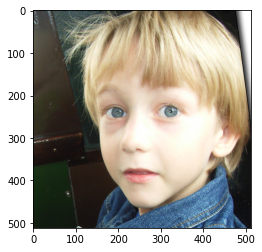

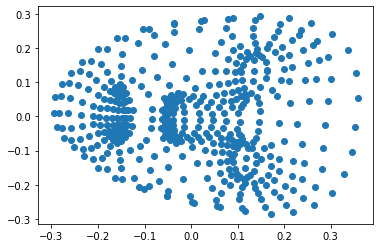

0.02694604876487231 0.12385114481402003 0.01533910607174336 0.5692525165967889


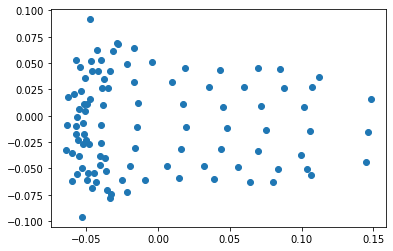

CeterisParibusDataset/0_0_0_0_0_1_1_0_0.png [0.51033579 0.3846123  0.10505191] [0.3096069  0.17303689 0.5173562 ]


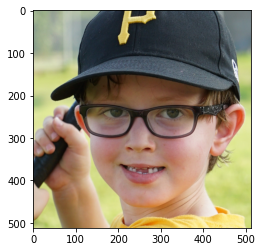

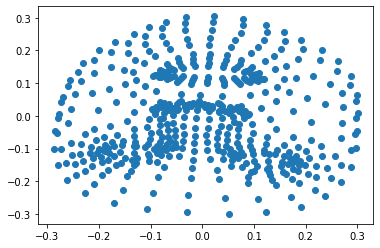

0.026174483829677277 0.15338396898132656 0.023526641940464547 0.898838811628807


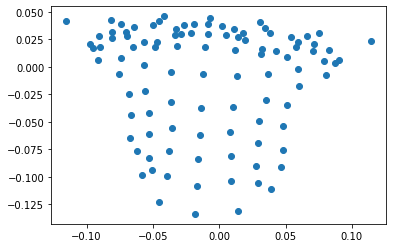

CeterisParibusDataset/0_0_0_0_1_0_2_0_0.png [0.45001554 0.42248869 0.12749577] [0.2095387 0.1888427 0.6016186]


In [5]:
foldername = "CeterisParibusDataset"
# foldername = "test"
IMAGE_FILES = [foldername+'/'+filename for filename in os.listdir(foldername) if 'png' in filename or 'jpg' in filename]

face_mesh =  mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5)

for filename in IMAGE_FILES[:2]:
    print('='*50)
    image = cv2.imread(filename)
    plt.imshow(image[:,:,::-1])
    plt.show()
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    face_landmarks = results.multi_face_landmarks[0]
    data = []
    for pt in face_landmarks.landmark:
        data.append([pt.x, pt.y, pt.z])
    data = np.array(data)
    
    pca = PCA(n_components=3)
    pca.fit(data)
    # u = pca.components_[0]
    # v = pca.components_[1]
    # w = pca.components_[2]
    # print(np.linalg.norm(u), np.linalg.norm(v), np.linalg.norm(w))
    trans_data = pca.transform(data)
    plt.scatter(trans_data[:,0], trans_data[:,1])
    plt.show()

    nose_data = data[nose_pts]
    trans_nose_data = pca.transform(nose_data)
    hull = ConvexHull(trans_nose_data[:,:2])
    depth = np.max(trans_nose_data[:,2])-np.min(trans_nose_data[:,2])
    print(hull.volume, depth, depth*depth,  depth*depth/hull.volume)
    plt.scatter(trans_nose_data[:,0], trans_nose_data[:,1])
    plt.show()


    result = np.zeros(pca.n_components)
    for ii in range(pca.n_components):
        X_trans_ii = np.zeros_like(trans_nose_data)
        X_trans_ii[:, ii] = trans_nose_data[:, ii]
        X_approx_ii = pca.inverse_transform(X_trans_ii)

        result[ii] = 1 - (np.linalg.norm(X_approx_ii - nose_data) /
                          np.linalg.norm(nose_data - pca.mean_)) ** 2


    print(filename, pca.explained_variance_ratio_, result)
    # std_trans = np.std(trans_data, axis=0)
    # std_trans_nose = np.std(trans_nose_data, axis=0)
    # print( result[-1]/pca.explained_variance_ratio_[-1] )

    # pcs = pca.components_
    # for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    #     # Afficher un segment de l'origine au point (x, y)
    #     plt.plot([0, x], [0, y], color='k')
    #     # Afficher le nom (data.columns[i]) de la performance
    #     plt.text(x, y,  str(i), fontsize='14')

    # # Afficher une ligne horizontale y=0
    # plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
    # Afficher une ligne verticale x=0
    # plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
    # plt.show()
    


